In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import nibabel as nib
import random
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

import dask.dataframe as dd

sys.path.append("../")
from src.utils import *
from src.LSN_roi import *

from models import dp_loss as dpl
from models import dp_utils as dpu

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

/home/nikhil/anaconda3/envs/green_compute/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Paths

In [2]:
project_dir = "../"
data_dir = "/home/nikhil/projects/brain_changes/data/ukbb/"

freesurfer_csv = f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv"

train_csv = f"{project_dir}metadata/metadata_train.csv"
test_csv = f"{project_dir}metadata/metadata_test.csv"

freesurfer_fields = f"{project_dir}/metadata/ukbb_freesurfer_fields.txt"

summary_results_dir = "/home/nikhil/projects/brain_changes/brain-diff/results/summary/"



## Filter followup subject using Dask dataframe (pandas will crash)

In [3]:
# import dask.dataframe as dd

# # Grab eids with ses-3 data
# freesurfer_df = pd.read_csv(freesurfer_csv,usecols=["eid","26501-3.0"])
# freesurfer_eids = freesurfer_df[~freesurfer_df["26501-3.0"].isna()]["eid"]

# # Read entire CSV using dask
# freesurfer_df = dd.read_csv(freesurfer_csv)
# followup_freesurfer_df = freesurfer_df[freesurfer_df["eid"].isin(freesurfer_eids)].compute()

# # Save filtered df
# followup_freesurfer_df.to_csv(f"{data_dir}imaging/freesurfer/ukb47552_followup_subset.csv")

## Grab phenotype fields (e.g. Thicknes, Volume, Area)

In [4]:
freesurfer_fields_df = pd.read_csv(freesurfer_fields,sep="	")
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["Description"].str.split(" ",1,expand=True)[0]
freesurfer_fields_df["phenotype"] = freesurfer_fields_df["phenotype"].replace({"Mean":"Mean Thickness"})
CT_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Mean Thickness"]["Field ID"]
volume_fields = freesurfer_fields_df[freesurfer_fields_df["phenotype"]=="Volume"]["Field ID"]

print(f"number of CT fields: {len(CT_fields)}, volume fields: {len(volume_fields)}")

number of CT fields: 62, volume fields: 62


## Read DKT volumes 

In [5]:
pheno_fields = CT_fields # + volume_fields
pheno_cols_ses2 = list(pheno_fields.astype(str) + "-2.0")
pheno_cols_ses3 = list(pheno_fields.astype(str) + "-3.0")
usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

print(f"reading {len(usecols)} columes")

freesurfer_df = pd.read_csv(freesurfer_csv, usecols=usecols)

# Remove eids with missing 2nd or 3rd ses data
eid_missing_data = freesurfer_df[freesurfer_df.isna().any(axis=1)]["eid"].values
print(f"number participants missing 2nd or 3rd ses freesurfer data: {len(eid_missing_data)}")

freesurfer_df = freesurfer_df[~freesurfer_df["eid"].isin(eid_missing_data)]
freesurfer_eids = freesurfer_df["eid"].values

print(f"available freesurfer subjects: {len(freesurfer_eids)}")


# scale data
# pheno_max_val = np.max(freesurfer_df[pheno_cols_ses2 + pheno_cols_ses3].values)
# print(f"Max pheno val: {pheno_max_val}")
# freesurfer_df[pheno_cols_ses2 + pheno_cols_ses3] = freesurfer_df[pheno_cols_ses2 + pheno_cols_ses3] / pheno_max_val

freesurfer_df.head()

reading 125 columes
number participants missing 2nd or 3rd ses freesurfer data: 63
available freesurfer subjects: 3237


,eid,27174-2.0,27174-3.0,27175-2.0,27175-3.0,27176-2.0,27176-3.0,27177-2.0,27177-3.0,27178-2.0,...,27293-2.0,27293-3.0,27294-2.0,27294-3.0,27295-2.0,27295-3.0,27296-2.0,27296-3.0,27297-2.0,27297-3.0
0,1000635,2.786,2.874,2.910,2.852,2.275,2.307,3.389,3.379,2.836,...,2.387,2.435,2.967,2.958,2.707,2.628,2.229,2.142,2.875,2.750
1,1008391,3.191,2.875,3.080,3.037,2.273,2.143,3.004,2.571,2.846,...,2.588,2.592,3.073,2.859,2.839,2.770,3.086,3.322,3.255,3.003
2,1010129,2.329,1.870,2.836,2.798,1.995,1.943,3.302,3.193,2.812,...,2.376,2.395,3.081,3.086,2.993,2.945,3.016,3.032,3.193,3.168
3,1010994,2.785,2.581,2.671,2.603,2.060,1.819,3.144,3.225,2.793,...,2.513,2.416,2.919,2.881,2.654,2.581,2.088,2.161,2.912,2.866
4,1013774,2.963,3.191,2.617,2.856,2.035,2.050,2.751,3.385,2.830,...,2.274,2.403,3.041,3.008,2.635,2.737,2.527,2.696,2.983,3.263


In [6]:
train_df = pd.read_csv(train_csv)
train_eids = train_df["eid"]
train_eids_avail = set(train_eids) & set(freesurfer_eids)
train_df = pd.merge(train_df, freesurfer_df, on="eid", how="inner")

test_df = pd.read_csv(test_csv)
test_eids = test_df["eid"]
test_eids_avail = set(test_eids) & set(freesurfer_eids)
test_df = pd.merge(test_df, freesurfer_df, on="eid", how="inner")

print(f"train samples: {len(train_eids)}, freesurfer data available: {len(train_eids_avail)}, overlap: {len(train_df)}")
print(f"test samples: {len(test_eids)}, freesurfer data available: {len(test_eids_avail)}, overlap: {len(test_df)}")

train samples: 2145, freesurfer data available: 1909, overlap: 1909
test samples: 1057, freesurfer data available: 958, overlap: 958


## Data-loaders

In [7]:
# n_samples = 50

batch_size = 10
transform = "random_swap" #only for training

# usecols = ["eid"] + pheno_cols_ses2 + pheno_cols_ses3

# data_df = pd.read_csv(freesurfer_csv, usecols=usecols)

train_dataset = UKBB_ROI_Dataset(train_df, pheno_cols_ses2, pheno_cols_ses3, transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = UKBB_ROI_Dataset(test_df, pheno_cols_ses2, pheno_cols_ses3, transform=None)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# iter(train_dataloader).next()
print(f"len train dataset: {len(train_dataset)}, test dataset: {len(test_dataset)}")

len train dataset: 1909, test dataset: 958


## CUDA

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    map_location=lambda storage, loc: storage.cuda()
else:
    map_location='cpu'

## Train model 

In [9]:
n_epochs = 10
input_size = len(pheno_cols_ses2)
hidden_size = 10
lr = 0.005

# model = LSN_FF(input_size,hidden_size=hidden_size)
model = LSN_FF_Linear(input_size,hidden_size=hidden_size)

model.train()

optimizer = torch.optim.Adam(model.parameters(), lr=lr) #optim.SGD(model.parameters(), lr=lr, momentum=0.5)                                                                                               
criterion = nn.MSELoss()  #nn.L1Loss() #

# using subset of train dataloader for debug
model, batch_loss_df, epoch_loss_df, preds_df = train(model,train_dataloader,optimizer,criterion,n_epochs)

Starting epoch 1
epoch 0 loss: 0.0160
Starting epoch 2
epoch 1 loss: 0.0062
Starting epoch 3
epoch 2 loss: 0.0057
Starting epoch 4
epoch 3 loss: 0.0056
Starting epoch 5
epoch 4 loss: 0.0053
Starting epoch 6
epoch 5 loss: 0.0055
Starting epoch 7
epoch 6 loss: 0.0055
Starting epoch 8
epoch 7 loss: 0.0054
Starting epoch 9
epoch 8 loss: 0.0053
Starting epoch 10
epoch 9 loss: 0.0053
epoch 9 loss: 0.0053


,epoch_loss
0,0.016038
1,0.006158
2,0.005705
3,0.005581
4,0.005334


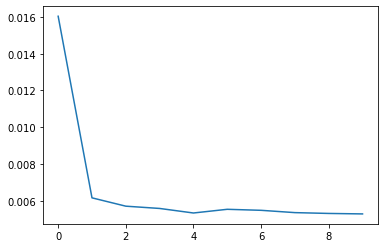

In [10]:

plt.plot(epoch_loss_df)
epoch_loss_df.head()

## Test perf

In [11]:

test_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)

eid_list, y_test_list, y_pred_list, test_loss1, test_loss2 = test(model, test_dataloader)
y_test = np.squeeze(np.vstack(y_test_list))
y_pred = np.squeeze(np.vstack(y_pred_list))

test_r1 = stats.pearsonr(y_pred[:,0],y_test[:,0])[0]
test_r2 = stats.pearsonr(y_pred[:,1],y_test[:,1])[0]   

test_age_1 = y_test[:,0]
test_age_2 = y_test[:,1]

test_brainage_1 = y_pred[:,0] # for two timepoints y is a matrix
test_brainage_2 = y_pred[:,1]                                    

df = pd.DataFrame()
df["eid"] = eid_list
df["test_age_1"] = test_age_1
df["test_age_2"] = test_age_2
df["test_brainage_1"] = test_brainage_1
df["test_brainage_2"] = test_brainage_2
df["test_loss1"] = test_loss1                    
df["test_loss2"] = test_loss2
df["test_r1"] = test_r1
df["test_r2"] = test_r2

# Test loss is L1 not MSE
test_loss = df["test_loss1"].mean()
print(f"test_loss: {test_loss}")

test_loss: 5.908695948317514


In [12]:
df

,eid,test_age_1,test_age_2,test_brainage_1,test_brainage_2,test_loss1,test_loss2,test_r1,test_r2
0,[4480975],55.000000,58.000000,63.629276,65.631470,8.629276,7.631470,0.357923,0.405303
1,[2143397],58.000000,60.000004,63.318913,65.405525,5.318913,5.405521,0.357923,0.405303
2,[5536763],55.000000,57.000000,62.678539,64.713982,7.678539,7.713982,0.357923,0.405303
3,[5908628],75.000000,77.000000,64.130455,66.301193,10.869545,10.698807,0.357923,0.405303
4,[2483372],58.000000,60.000004,63.655045,65.613533,5.655045,5.613529,0.357923,0.405303
...,...,...,...,...,...,...,...,...,...
1904,[2936817],52.999996,55.000000,64.126030,66.278580,11.126034,11.278580,0.357923,0.405303
1905,[1564835],50.000000,52.000000,63.779892,65.517387,13.779892,13.517387,0.357923,0.405303
1906,[4311743],58.000000,60.000004,63.185322,65.186600,5.185322,5.186596,0.357923,0.405303
1907,[1428093],69.000000,71.000000,62.610703,64.990631,6.389297,6.009369,0.357923,0.405303


## Generate configs for CC runs

In [ ]:
config_df = pd.DataFrame(columns=["hidden_size","transform","phenotype"])
hidden_size_list = [10,50,100]
transform_list = [None, "random_swap"]
phenotype_list = ["CT"] #,"volume","both"

i = 0
for hidden_size in hidden_size_list:
    for transform in transform_list:
        for phenotype in phenotype_list:
            config_df.loc[i] = [hidden_size,transform,phenotype]
            i += 1

print(config_df.shape)
config_df

In [ ]:
# run_id = "run_1"
# config_path = f"../results/LSN_roi/configs/config_{run_id}.csv"
# config_df.to_csv(config_path)

## Plot batch runs

In [16]:
def collate_results(file_prefix, config_id_list):
    results_df = pd.DataFrame()
    for config_id in config_id_list:
        results_csv = f"{file_prefix}_{config_id}.csv"
        _df = pd.read_csv(results_csv)
        _df["config_id"] = config_id
        results_df = results_df.append(_df)

    return results_df


In [17]:
run_id = "run_3"
config_id_list = np.arange(6)

loss_csv = f"../results/LSN_roi/{run_id}/freesurfer_train_loss_config"
perf_csv = f"../results/LSN_roi/{run_id}/freesurfer_perf_config"

loss_df = collate_results(loss_csv, config_id_list)
perf_df = collate_results(perf_csv, config_id_list)

loss_df = loss_df.rename(columns={"Unnamed: 0":"epoch"})

perf_df.head()

,Unnamed: 0,eid,age_at_ses2,age_at_ses3,brainage_at_ses2,brainage_at_ses3,test_loss1,test_loss2,test_r1,test_r2,visit_order,config_id
0,0,4071544,66.0,68.000000,63.994347,66.140640,2.005653,1.859360,0.527687,0.525679,"B,F",0
1,1,6005293,61.0,63.000000,62.105793,64.134090,1.105793,1.134087,0.527687,0.525679,"B,F",0
2,2,5739520,61.0,63.000000,61.967766,64.306435,0.967766,1.306435,0.527687,0.525679,"B,F",0
3,3,1308382,51.0,52.999996,60.163765,62.425680,9.163765,9.425682,0.527687,0.525679,"B,F",0
4,4,2991501,58.0,60.000004,55.407970,57.766140,2.592030,2.233864,0.527687,0.525679,"B,F",0


## Plot learning curves

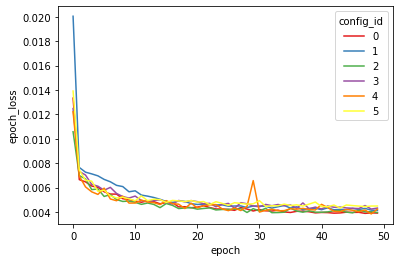

In [18]:
g = sns.lineplot(x="epoch", y="epoch_loss", data=loss_df, hue="config_id", palette="Set1")

## Plot prediction perf

config_id  visit_order
0          B,F            5.213407
           F,B            5.834642
1          B,F            5.281069
           F,B            5.308126
2          B,F            5.174167
           F,B            5.808204
3          B,F            5.043404
           F,B            5.118056
4          B,F            6.562731
           F,B            6.932990
5          B,F            5.582094
           F,B            5.653630
Name: test_loss, dtype: float64


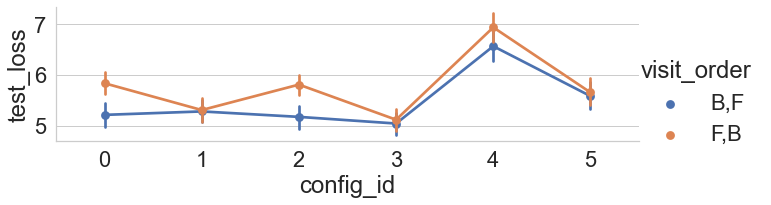

In [19]:
plot_df = perf_df.copy()
plot_df["test_loss"] = 0.5 * (plot_df["test_loss1"] + plot_df["test_loss2"])

print(plot_df.groupby(["config_id", "visit_order"]).mean()["test_loss"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_loss",x="config_id",hue="visit_order", height=3, aspect=3, kind="point", 
                    sharey=False, data=plot_df)

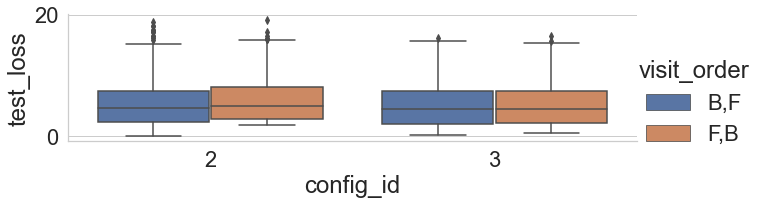

In [20]:
best_configs = [2,3]
plot_df = plot_df[plot_df["config_id"].isin(best_configs)]

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="test_loss",x="config_id",hue="visit_order", height=3, aspect=3, kind="box", 
                    sharey=False, data=plot_df)

In [21]:
# config 0: no data_aug, config 1: data aug
perf_df = perf_df[(perf_df["config_id"].isin(best_configs)) & (perf_df["visit_order"]=="B,F")].copy()
perf_df.loc[perf_df["config_id"]==best_configs[0], "data_aug"] = False
perf_df.loc[perf_df["config_id"]==best_configs[1], "data_aug"] = True

perf_df["model"] = "LSN"
perf_df["baseline_err"] = perf_df["brainage_at_ses2"] - perf_df["age_at_ses2"]
perf_df["followup_err"] = perf_df["brainage_at_ses3"] - perf_df["age_at_ses3"]
perf_df["brainage_delta"] = perf_df["brainage_at_ses3"] - perf_df["brainage_at_ses2"]
perf_df["chronoage_delta"] = perf_df["age_at_ses3"] - perf_df["age_at_ses2"]

perf_df["delta_err"] = perf_df["brainage_delta"] - perf_df["chronoage_delta"]

perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

n_BBs = perf_df["Benjamin_Button"].sum()
print(f"n BBs: {n_BBs} ({100*n_BBs/len(plot_df):4.3f}%)")

perf_df_melt = perf_df.melt(id_vars=["eid", "model", "data_aug", "visit_order", "age_at_ses2", "brainage_at_ses2", "age_at_ses3", "brainage_at_ses3", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err'],
              var_name='err_type', value_name='error')

perf_df.head()

n BBs: 150 (3.914%)


,Unnamed: 0,eid,age_at_ses2,age_at_ses3,brainage_at_ses2,brainage_at_ses3,test_loss1,test_loss2,test_r1,test_r2,visit_order,config_id,data_aug,model,baseline_err,followup_err,brainage_delta,chronoage_delta,delta_err,Benjamin_Button
0,0,4071544,66.0,68.000000,65.073430,67.391680,0.926567,0.608322,0.533192,0.530965,"B,F",2,False,LSN,-0.926570,-0.608320,2.318250,2.000000,0.318250,False
1,1,6005293,61.0,63.000000,61.515106,63.933628,0.515106,0.933628,0.533192,0.530965,"B,F",2,False,LSN,0.515106,0.933628,2.418522,2.000000,0.418522,False
2,2,5739520,61.0,63.000000,62.135940,64.490720,1.135941,1.490723,0.533192,0.530965,"B,F",2,False,LSN,1.135940,1.490720,2.354780,2.000000,0.354780,False
3,3,1308382,51.0,52.999996,59.930058,62.508900,8.930058,9.508904,0.533192,0.530965,"B,F",2,False,LSN,8.930058,9.508904,2.578842,1.999996,0.578846,False
4,4,2991501,58.0,60.000004,55.315720,58.173706,2.684280,1.826298,0.533192,0.530965,"B,F",2,False,LSN,-2.684280,-1.826298,2.857986,2.000004,0.857982,False


err_type      data_aug
baseline_err  False       5.192908
              True        5.018465
delta_err     False       0.541286
              True        1.735667
followup_err  False       5.155427
              True        5.068343
Name: abs_error, dtype: float64


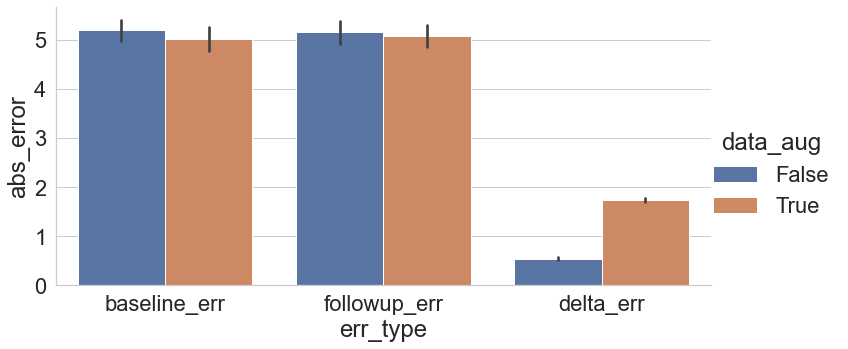

In [22]:
plot_df = perf_df_melt.copy()

plot_df["abs_error"] = np.abs(plot_df["error"]) 

print(plot_df.groupby(["err_type","data_aug"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", hue="data_aug", kind="bar", data=plot_df,aspect=2)

In [23]:
save_summary_results = False
if save_summary_results:
    perf_df_melt.to_csv(f"{summary_results_dir}LSN_model_two_visit_train_two_visit_subset_test_two_visit_subset.csv")

## Legacy plots

In [ ]:
plot_df = perf_df.copy()
plot_df = plot_df[plot_df["config_id"].isin([2,3])]

plot_df["test_MAE"] = 0.5 * (plot_df["test_MAE1"] + plot_df["test_MAE1"])
plot_df["brainage_diff"] = plot_df["test_brainage_2"] - plot_df["test_brainage_1"]
plot_df["chronoage_diff"] = plot_df["test_age_2"] - plot_df["test_age_1"]

with sns.axes_style("whitegrid"):
    fig, ax = plt.subplots(figsize=(20,10))
    g = sns.scatterplot(x="eid",y="brainage_diff",hue="visit_order", style="config_id",data=plot_df, ax=ax)

In [ ]:
plot_df1 = plot_df[plot_df["visit_order"]=="B,F"][["eid","config_id","brainage_diff"]]
plot_df2 = plot_df[plot_df["visit_order"]=="F,B"][["eid","config_id","brainage_diff"]]
plot_df_long = pd.merge(plot_df1,plot_df2,on=["eid","config_id"])
plot_df_long = plot_df_long.rename(columns={"brainage_diff_x":"brainage_diff for B,F", "brainage_diff_y":"brainage_diff for F,B"})

with sns.axes_style("whitegrid"):
    g = sns.jointplot(x="brainage_diff for B,F", y="brainage_diff for F,B", hue="config_id", data=plot_df_long)

# Vector similarity

In [ ]:
perf_df.head()

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance

chrno_age = perf_df[["test_age_1","test_age_2"]].values
brain_age = perf_df[["test_brainage_1","test_brainage_2"]].values

sim_list = []
for i in range(len(chrno_age)):
    cos_sim = 1 - distance.cosine(chrno_age[i],brain_age[i])
    sim_list.append(cos_sim)

In [ ]:
plot_df = perf_df.copy()
plot_df["cosine_sim"] = sim_list

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="cosine_sim",x="config_id",hue="visit_order", height=3, aspect=3, kind="point", 
                    sharey=False, data=plot_df)

In [ ]:
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(y="cosine_sim",x="config_id",hue="visit_order", height=3, aspect=3, kind="box", 
                    sharey=False, data=plot_df)